In [3]:
def get_mnist():
    # The code to download the mnist data original came from
    # https://cntk.ai/pythondocs/CNTK_103A_MNIST_DataLoader.html

    import gzip
    import numpy as np
    import os
    import struct

    from urllib.request import urlretrieve

    def load_data(src, num_samples):
        print("Downloading " + src)
        gzfname, h = urlretrieve(src, "./delete.me")
        print("Done.")
        try:
            with gzip.open(gzfname) as gz:
                n = struct.unpack("I", gz.read(4))
                # Read magic number.
                if n[0] != 0x3080000:
                    raise Exception("Invalid file: unexpected magic number.")
                # Read number of entries.
                n = struct.unpack(">I", gz.read(4))[0]
                if n != num_samples:
                    raise Exception(
                        "Invalid file: expected {0} entries.".format(num_samples)
                    )
                crow = struct.unpack(">I", gz.read(4))[0]
                ccol = struct.unpack(">I", gz.read(4))[0]
                if crow != 28 or ccol != 28:
                    raise Exception(
                        "Invalid file: expected 28 rows/cols per image."
                    )
                # Read data.
                res = np.frombuffer(
                    gz.read(num_samples * crow * ccol), dtype=np.uint8
                )
        finally:
            os.remove(gzfname)
        return res.reshape((num_samples, crow, ccol)) / 256


    def load_labels(src, num_samples):
        print("Downloading " + src)
        gzfname, h = urlretrieve(src, "./delete.me")
        print("Done.")
        try:
            with gzip.open(gzfname) as gz:
                n = struct.unpack("I", gz.read(4))
                # Read magic number.
                if n[0] != 0x1080000:
                    raise Exception("Invalid file: unexpected magic number.")
                # Read number of entries.
                n = struct.unpack(">I", gz.read(4))
                if n[0] != num_samples:
                    raise Exception(
                        "Invalid file: expected {0} rows.".format(num_samples)
                    )
                # Read labels.
                res = np.frombuffer(gz.read(num_samples), dtype=np.uint8)
        finally:
            os.remove(gzfname)
        return res.reshape((num_samples))


    def try_download(data_source, label_source, num_samples):
        data = load_data(data_source, num_samples)
        labels = load_labels(label_source, num_samples)
        return data, labels

    # Not sure why, but yann lecun's website does no longer support
    # simple downloader. (e.g. urlretrieve and wget fail, while curl work)
    # Since not everyone has linux, use a mirror from uni server.
    #     server = 'http://yann.lecun.com/exdb/mnist'
    server = 'https://raw.githubusercontent.com/fgnt/mnist/master'

    # URLs for the train image and label data
    url_train_image = f'{server}/train-images-idx3-ubyte.gz'
    url_train_labels = f'{server}/train-labels-idx1-ubyte.gz'
    num_train_samples = 60000

    print("Downloading train data")
    train_features, train_labels = try_download(url_train_image, url_train_labels, num_train_samples)

    # URLs for the test image and label data
    url_test_image = f'{server}/t10k-images-idx3-ubyte.gz'
    url_test_labels = f'{server}/t10k-labels-idx1-ubyte.gz'
    num_test_samples = 10000

    print("Downloading test data")
    test_features, test_labels = try_download(url_test_image, url_test_labels, num_test_samples)

    return train_features, train_labels, test_features, test_labels


In [4]:
train_X, train_y, test_X, test_y = get_mnist()


Done.
Done.
Done.
Done.


In [5]:
test_X

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [8]:
latent_dim = 50 #潛在空間維度
batch_size = 128
epochs = 30


In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
class VAE(nn.Module):#代表說我這邊開始類神經網路，以後要寫成類神經網路都要這樣做
  def __init__(self,latent_dim) -> None:
    #encoder
      super().__init__() #要呼叫類神經網路父類別的初始方法才可以設定其他屬性
      self.encoder = nn.Sequential(nn.Linear(28 * 28,400),nn.ReLU())#這邊要設encoder的架構，首先輸入要設置28*28的圖片，然後將她轉乘400維的圖片，最後經過relu激活函數
      self.fc_mu = nn.Linear(400,latent_dim)#這邊要設定平均值的維度
      self.fc_logvar = nn.Linear(400,latent_dim)#這邊要設定方差的維度
    #decoder
      self.decoder = nn.Sequential(nn.Linear(latent_dim,400),nn.ReLU(),nn.Linear(400,28 * 28),nn.Sigmoid())#這邊要設定decoder的架構，也就是還原圖片，主要就是將濃縮的維度還原成28* 28大小
  def encode(self,x):
     h = self.encoder(x)#因為module 裡面有_call_，故當我呼叫module就可以直接forward
     return self.fc_mu(h),self.fc_logvar(h)
  def reparameterize(self,mu,logvar):
    std = torch.exp(0.5 * logvar)#計算標準差
    eps = torch.randn_like(std)#取得一個跟std一樣shape的亂數分布，因為要讓每一維都有乘到
    return mu + std * eps
  def decode(self,z):
    return self.decoder(z)
  def forward(self,x):
    x = x.view(-1,28 * 28)
    mu,logvar = self.encode(x)
    z = self.reparameterize(mu,logvar)
    recon_x = self.decode(z)
    return recon_x,mu,logvar




In [11]:
def vae_loss(recon_x, x, mu, logvar):#比較生成和原圖
    x = x.view(-1, 28 * 28)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [12]:
#將程式碼搬到cpu或gpu
#這個to代表說如果我設計的模型使用self.xxx= 他就會自動搬到cpu 或是gpu上
model = VAE(latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)



In [13]:
import torch
from torch.utils.data import TensorDataset, DataLoader


In [14]:
#將資料轉為張量，因為原本是numpy array
train_X_tensor = torch.tensor(train_X, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y, dtype=torch.long)
test_X_tensor = torch.tensor(test_X, dtype=torch.float32)
test_y_tensor = torch.tensor(test_y, dtype=torch.long)

In [15]:
train_dataset = TensorDataset(train_X_tensor, train_y_tensor)#在訓練的時候方便，將標籤和訓練綁再一起 形成一個資料集
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)#分批取資料，控制每次給模型的資料數，shuffle 是將順序打亂以防模型學到提升泛化能力

In [16]:
for epoch in range(1,epochs + 1):
  model.train()#要找到最佳解
  total_loss = 0 #初始loss給他0
  for data ,_ in train_loader:#一筆一筆取出來，_代表不需要這個
     data = data.to(device)#將資料移到device上進行訓練
     optimizer.zero_grad()#每次都重新零梯度
     recon_x, mu, logvar = model(data)
     loss = vae_loss(recon_x, data, mu, logvar)
     loss.backward()#反向傳播，算出梯度
     optimizer.step()#更新參數
     total_loss += loss.item()#將loss 加起來
  avg_loss = total_loss / len(train_loader.dataset)
  print(f'Epoch {epoch}, Average Loss: {avg_loss:.4f}')


Epoch 1, Average Loss: 170.0858
Epoch 2, Average Loss: 127.8353
Epoch 3, Average Loss: 118.0501
Epoch 4, Average Loss: 113.6859
Epoch 5, Average Loss: 111.3358
Epoch 6, Average Loss: 109.7928
Epoch 7, Average Loss: 108.6904
Epoch 8, Average Loss: 108.0048
Epoch 9, Average Loss: 107.3804
Epoch 10, Average Loss: 106.9385
Epoch 11, Average Loss: 106.4742
Epoch 12, Average Loss: 106.1832
Epoch 13, Average Loss: 105.8964
Epoch 14, Average Loss: 105.6573
Epoch 15, Average Loss: 105.4941
Epoch 16, Average Loss: 105.2080
Epoch 17, Average Loss: 105.0730
Epoch 18, Average Loss: 104.8882
Epoch 19, Average Loss: 104.7367
Epoch 20, Average Loss: 104.6005
Epoch 21, Average Loss: 104.4852
Epoch 22, Average Loss: 104.3942
Epoch 23, Average Loss: 104.2544
Epoch 24, Average Loss: 104.1222
Epoch 25, Average Loss: 104.0204
Epoch 26, Average Loss: 103.9654
Epoch 27, Average Loss: 103.8812
Epoch 28, Average Loss: 103.7766
Epoch 29, Average Loss: 103.6502
Epoch 30, Average Loss: 103.6795


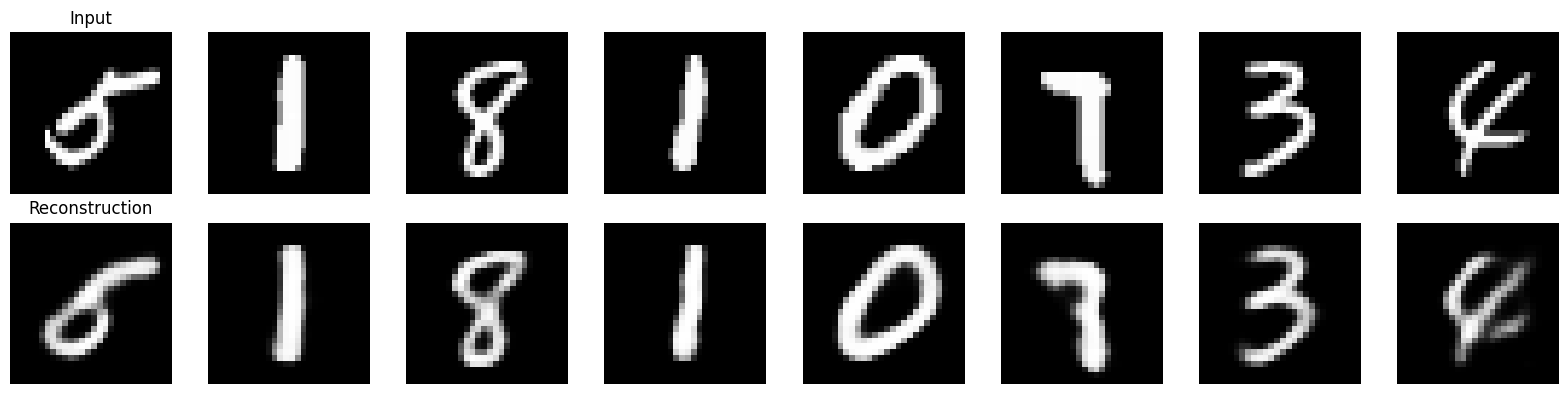

In [31]:
model.eval()
with torch.no_grad():#不進行計算梯度，以防消耗空間
    x, _ = next(iter(train_loader))     # 取一小 batch (16張)，
    x = x.to(device)
    recon_x, _, _ = model(x)
    x = x.cpu()
    recon_x = recon_x.cpu()#都搬回 CPU，因為 matplotlib 畫圖只能吃 CPU tensor 或 numpy array

    n = 8   # 顯示幾張
    plt.figure(figsize=(16, 4))
    for i in range(n):
        # 原圖
        plt.subplot(2, n, i + 1)
        plt.imshow(x[i].squeeze(), cmap='gray')#sequeeze將多餘的維度去掉
        plt.axis('off')#把這張小圖的 x/y 座標軸全部隱藏，不顯示任何數字或線條
        if i == 0: plt.title('Input')
        # 重建圖
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(recon_x[i].view(28,28), cmap='gray')
        plt.axis('off')
        if i == 0: plt.title('Reconstruction')
    plt.tight_layout()#plt.tight_layout() 是 matplotlib 常用的「自動排版指令」，它的意思是：「讓子圖（subplot）之間自動調整間距，不會重疊，排列得更美觀！」
    plt.show()